In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import curve_fit


# plot speedscaling for all wBA

In [3]:
home = os.path.expanduser("~")

net = f'ff_linear_600'
filepath = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_wGA.csv')


# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_wGA.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

# calculate anticipationwTOTwith respect to 
df['ant_RB_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RB'] 
df['ant_RB_bar_space'] = df['ant_RB_bar_time']* df['speed']



# df['wTOT'] = df['wTOT'].round()
df['speed'] = df['speed'].round(2)
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'wGA'],
      dtype='object')


In [4]:
df['wGA'].unique()

array([0.005 , 0.0054, 0.0058, 0.0062, 0.0066, 0.007 , 0.0074, 0.0079,
       0.0083, 0.0087, 0.0091, 0.0095, 0.0099, 0.0103, 0.0107, 0.0111,
       0.0115, 0.0119, 0.0123, 0.0128, 0.0132, 0.0136, 0.014 , 0.0144,
       0.0148, 0.0152, 0.0156, 0.016 , 0.0164, 0.0168, 0.0172, 0.0177,
       0.0181, 0.0185, 0.0189, 0.0193, 0.0197, 0.0201, 0.0205, 0.0209,
       0.0213, 0.0217, 0.0221, 0.0226, 0.023 , 0.0234, 0.0238, 0.0242,
       0.0246, 0.025 ])

In [5]:
# dl = df[df['wBA'] == 1.0]
# #dl = df[df['wTOT'] == -101.0]
# #dl = dl[dl['speed'] == 1.05]
# idx = dl['ant_RG_bar_space'].index
# len(idx)


# for x,i in enumerate(idx):


#     r = response_data[f'{i}'].dropna()
#     tps = len(r)
#     speed = dl['speed'][dl.index[x]]
#     print(tps,speed)
#     tpm = dl['tp_rf_GC_mid'][dl.index[x]]
#     print(tpm)
#     time = (np.arange(0,tps)*0.01 -tpm)*speed
#     plt.plot(time,r,label = f'{i}')
# plt.legend()


/tmp/ipykernel_514140/2103245444.py:45: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
/tmp/ipykernel_514140/2103245444.py:121: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


Text(847.5972222222223, 0.5, '$\\Delta X$')

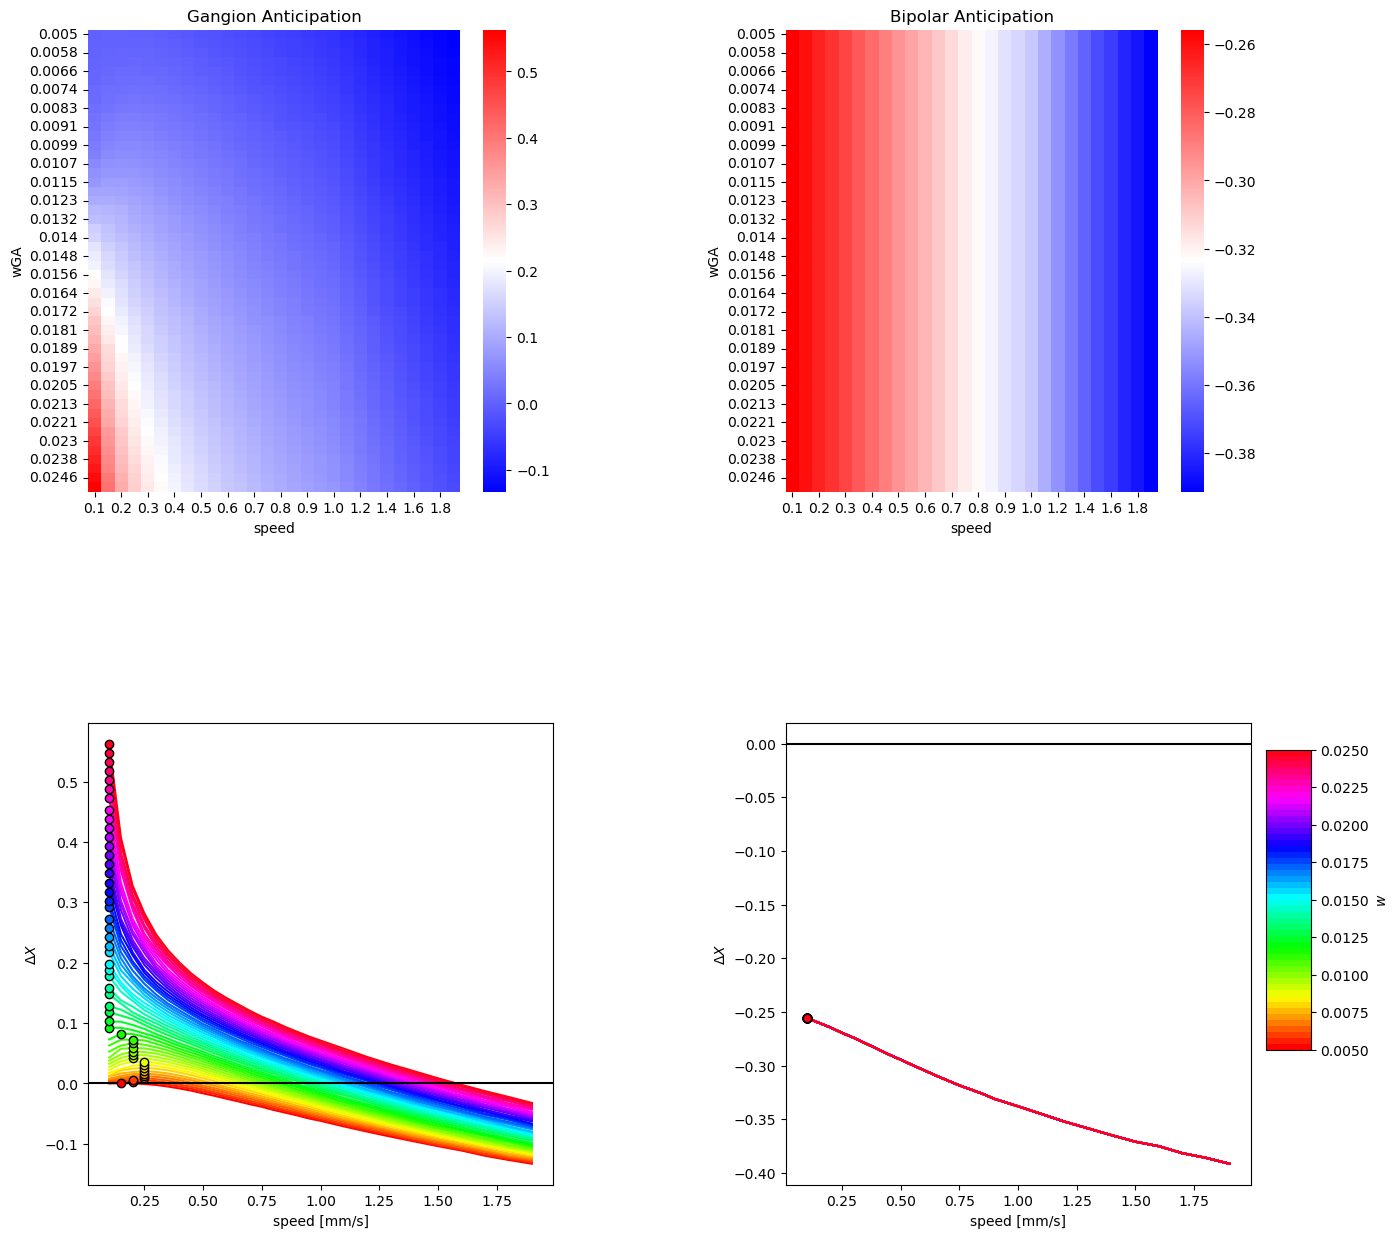

In [6]:

figure = plt.figure(figsize = (15,15))
gs = figure.add_gridspec(2,2)

figure.subplots_adjust(wspace = 0.5,hspace = 0.5)


cmapg = plt.get_cmap('hsv', len(df['wGA'].unique()))
cmapb = plt.get_cmap('hsv', len(df['wGA'].unique()))

cNorm = colors.Normalize(vmin =df['wGA'].min(), vmax = df['wGA'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapb)

cbar_ax2 = figure.add_axes([.91, .2, .03, .2])
cbar_ax2.set_ylabel(r'$w$')
figure.colorbar(scalarMap,
             cax=cbar_ax2, orientation='vertical', label=r'$w$')

var = 'ant_RG_bar_space'
fig = figure.add_subplot(gs[0,0])
fig.set_title('Gangion Anticipation')
ax = figure.add_subplot(gs[1,0])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'wGA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['wGA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wGA','tauTOT', 'tauA', 'wAB'])
pref_speeds_G = []
pref_amp_G = []
weights_G = []
anips_G = []

best_weights_G = []
vals_G = []
best_amp_G = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'w = {w2}',color = cmapg(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapg(x), edgecolor = 'k', zorder = 10)

    pref_speeds_G.append(speeds[maxi])
    pref_amp_G.append(cur[maxi])
    weights_G.append(w2)
    anips_G.append(cur)

anipis_G = np.asarray(anips_G)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_G[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_G[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_G[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_G[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_G[best_idx_lower]
        best_ani = anipis_G[best_idx_lower,i]
    else:
        best_weight = weights_G[best_idx_upper]
        best_ani = anipis_G[best_idx_upper,i]

    best_weights_G.append(best_weight)

    vals_G.append(best_ani)
    best_amp_G.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')

#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')


var = 'ant_RB_bar_space'
fig = figure.add_subplot(gs[0,1])
fig.set_title('Bipolar Anticipation')
ax = figure.add_subplot(gs[1,1])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'wGA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['wGA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wGA','tauTOT', 'tauA', 'wAB'])
pref_speeds_B = []
pref_amp_B = []
weights_B = []
anipis_B = []

best_weights_B = []
vals_B = []
best_amp_B = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var],color = cmapb(x))#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapb(x), edgecolor = 'k', zorder = 10)

    pref_speeds_B.append(speeds[maxi])
    pref_amp_B.append(cur[maxi])
    weights_B.append(w2)
    anipis_B.append(cur)


anipis_B = np.asarray(anipis_B)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_B[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_B[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_B[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_B[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_B[best_idx_lower]
        best_ani = anipis_B[best_idx_lower,i]
    else:
        best_weight = weights_B[best_idx_upper]
        best_ani = anipis_B[best_idx_upper,i]

    best_weights_B.append(best_weight)

    vals_B.append(best_ani)
    best_amp_B.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')



#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')
# figure.legend(bbox_to_anchor = (1.2,1))

## optimal weight for a set amout of anticipation 

In [7]:

# fig = plt.figure()
# gs = fig.add_gridspec(2,3)


# ax = fig.add_subplot(gs[0,0])
# plt.plot(speeds,best_weights_B)
# plt.scatter(speeds,best_weights_B)

# ax = fig.add_subplot(gs[0,1])
# plt.plot(speeds,vals_B)


# ax = fig.add_subplot(gs[0,2])
# plt.plot(speeds,vals_B)




# ax = fig.add_subplot(gs[1,0])
# plt.plot(speeds,best_weights_G)
# plt.scatter(speeds,best_weights_G)

# ax = fig.add_subplot(gs[1,1])
# plt.plot(speeds,vals_G)


# ax = fig.add_subplot(gs[1,2])
# plt.plot(speeds,vals_G)

## weight for preferred speed

Text(0.5, 0, 'w')

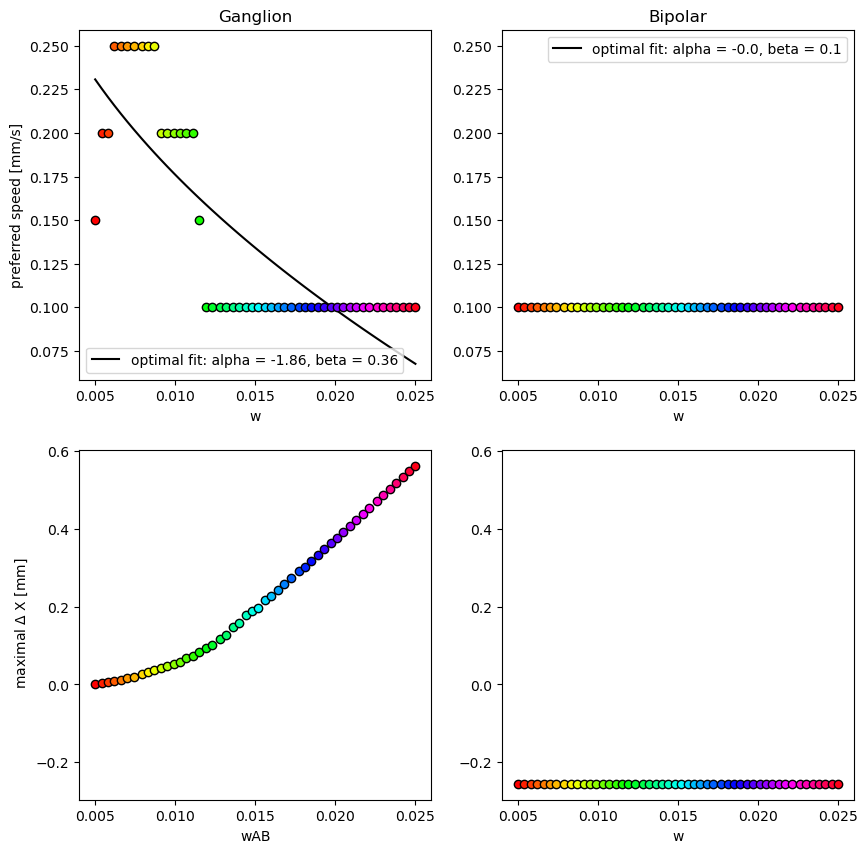

In [8]:

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta



fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,2)




weights = np.asarray(weights_G)  # bc w = wAB*wBA
pref_speeds = np.asarray(pref_speeds_G)
popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,0])

ax.set_title('Ganglion')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel('w')
plt.ylabel('preferred speed [mm/s]')
plt.legend()

axs = ax




ax = fig.add_subplot(gs[1,0])
ax.set_title('')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_G[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)


plt.xlabel('wAB')
plt.ylabel(r' maximal $\Delta$ X [mm]')

axa = ax





weights = np.asarray(weights_B)
pref_speeds = np.asarray(pref_speeds_B)

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta


popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,1],sharey = axs)

ax.set_title('Bipolar')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel('w')
plt.legend()


ax = fig.add_subplot(gs[1,1],sharey = axa)
ax.set_title(' ')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_B[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)

plt.xlabel('w')

# plot speedscaling for all tauA/B, relative difference TODO !!

In [10]:
net = f'ff_linear_600'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_tauBrel.csv')

# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_tauBrel.csv')

print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']



# calculate anticipation with respect to 
df['ant_RB_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RB'] 
df['ant_RB_bar_space'] = df['ant_RB_bar_time']* df['speed']

df['wGA'] = -1*df['wGA']
df['wGA'] = df['wGA'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])

speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['tauA'].unique(),df['tauB'].unique()



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'x',
       'wGA'],
      dtype='object')


(array([0.15]),
 array([ -0.1765,  -0.1867,  -0.1982,  -0.2112,  -0.226 ,  -0.243 ,
         -0.2628,  -0.2862,  -0.3141,  -0.348 ,  -0.3901,  -0.4439,
         -0.5148,  -0.6127,  -0.7565,  -0.9887,  -1.4262,  -2.5591,
        -12.4275,   4.3491,   1.8511,   1.1757,   0.8614,   0.6797,
          0.5613,   0.478 ,   0.4163,   0.3686,   0.3308,   0.3   ]))

In [11]:
# dl = df[df['tauA'] == 0.4]
# #dl = df[df['wTOT'] == -101.0]
# # dl = dl[dl['speed'] == 1.0 ]
# idx = dl['ant_RG_bar_space'].index
# len(idx)


# for x,i in enumerate(idx):


#     r = response_data[f'{i}'].dropna()
#     tps = len(r)
#     speed = dl['speed'][dl.index[x]]
#     print(tps,speed)
#     tpm = dl['tp_rf_GC_mid'][dl.index[x]]
#     print(tpm)
#     time = (np.arange(0,tps)*0.01 -tpm)*speed
#     plt.plot(time,r,label = f'{i}')
# plt.legend()

/tmp/ipykernel_514140/1394612287.py:45: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
/tmp/ipykernel_514140/1394612287.py:123: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


Text(847.5972222222223, 0.5, '$\\Delta X$')

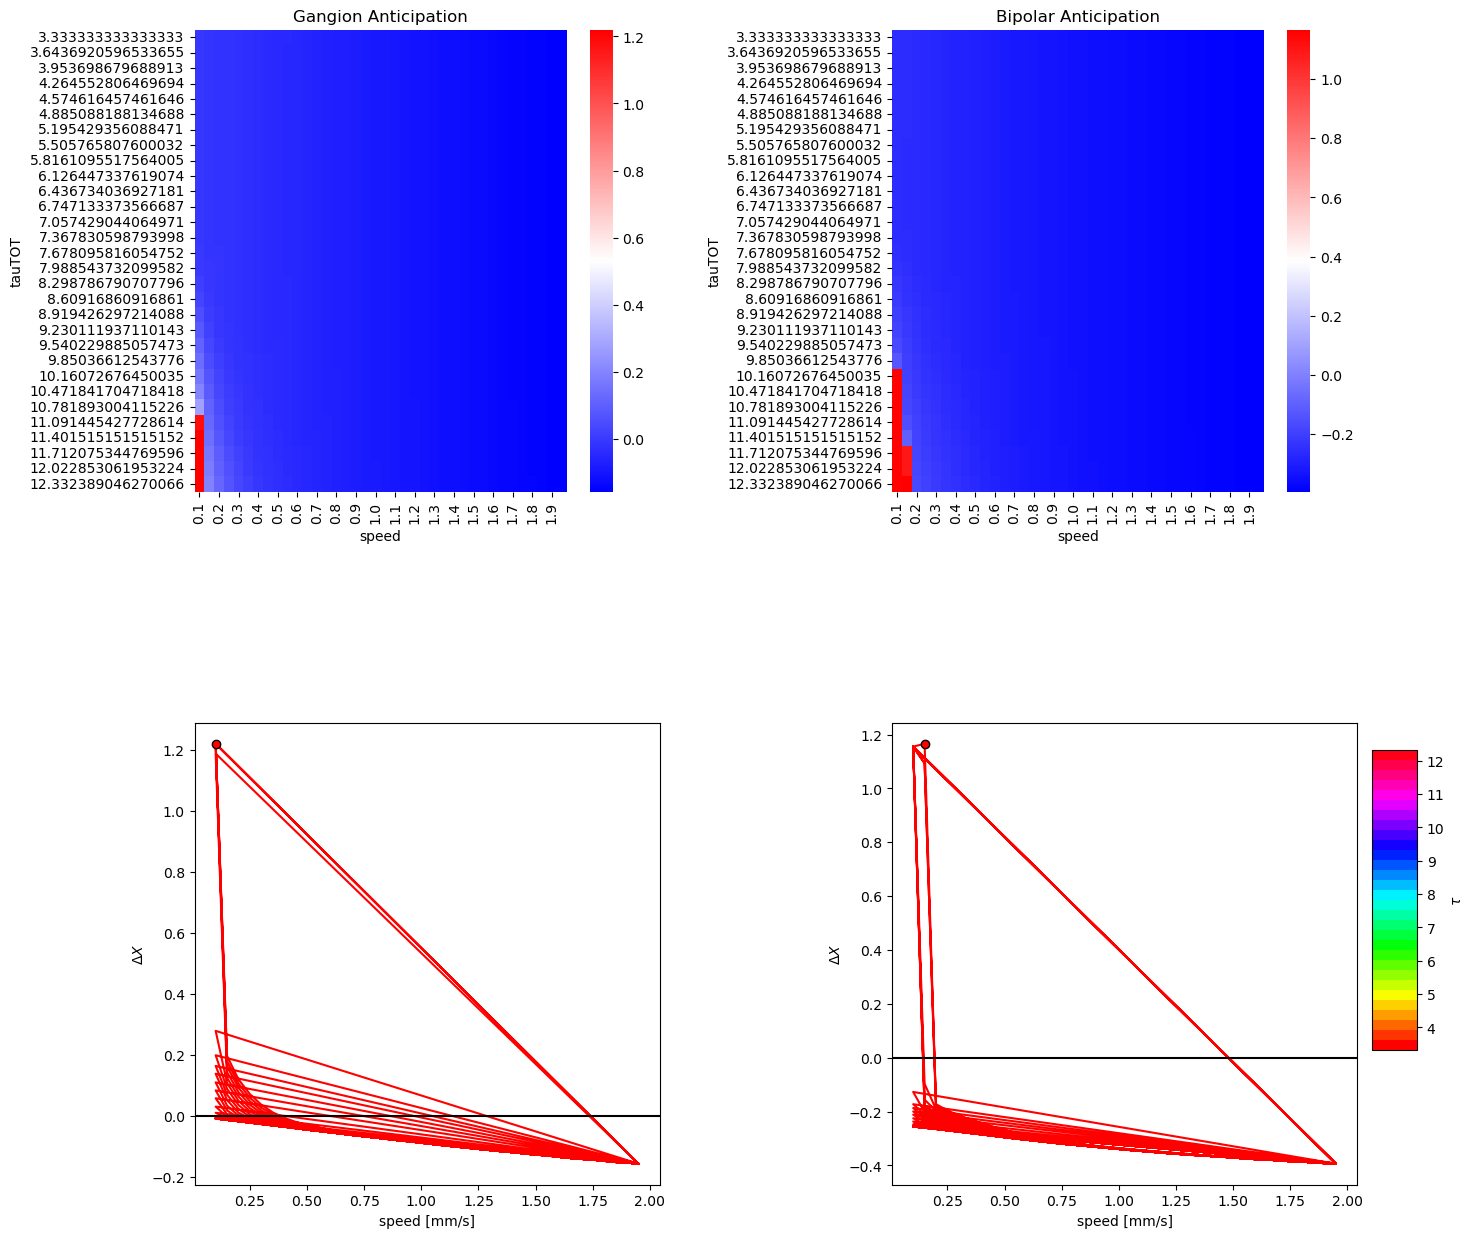

In [12]:


figure = plt.figure(figsize = (15,15))
gs = figure.add_gridspec(2,2)

figure.subplots_adjust(wspace = 0.5,hspace = 0.5)


cmapg = plt.get_cmap('hsv', len(df['tauTOT'].unique()))
cmapb = plt.get_cmap('hsv', len(df['tauTOT'].unique()))

cNorm = colors.Normalize(vmin =df['tauTOT'].min(), vmax = df['tauTOT'].max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapb)

cbar_ax2 = figure.add_axes([.91, .2, .03, .2])
cbar_ax2.set_ylabel(r'$\tau$')
figure.colorbar(scalarMap,
             cax=cbar_ax2, orientation='vertical', label=r'$\tau$')

var = 'ant_RG_bar_space'
fig = figure.add_subplot(gs[0,0])
fig.set_title('Gangion Anticipation')
ax = figure.add_subplot(gs[1,0])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauTOT',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wGA','tauTOT', 'tauA', 'wAB'])
pref_speeds_G = []
pref_amp_G = []
weights_G = []
anips_G = []

best_weights_G = []
vals_G = []
best_amp_G = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'tauTOT = {w2}',color = cmapg(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapg(x), edgecolor = 'k', zorder = 10)

    pref_speeds_G.append(speeds[maxi])
    pref_amp_G.append(cur[maxi])
    weights_G.append(w2)
    anips_G.append(cur)

anipis_G = np.asarray(anips_G)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_G[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_G[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_G[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_G[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_G[best_idx_lower]
        best_ani = anipis_G[best_idx_lower,i]
    else:
        best_weight = weights_G[best_idx_upper]
        best_ani = anipis_G[best_idx_upper,i]

    best_weights_G.append(best_weight)

    vals_G.append(best_ani)
    best_amp_G.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')

#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')




var = 'ant_RB_bar_space'
fig = figure.add_subplot(gs[0,1])
fig.set_title('Bipolar Anticipation')
ax = figure.add_subplot(gs[1,1])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauTOT',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wGA','tauTOT', 'tauA', 'wAB'])
pref_speeds_B = []
pref_amp_B = []
weights_B = []
anipis_B = []

best_weights_B = []
vals_B = []
best_amp_B = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var],color = cmapb(x))#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi],color = cmapb(x), edgecolor = 'k', zorder = 10)

    pref_speeds_B.append(speeds[maxi])
    pref_amp_B.append(cur[maxi])
    weights_B.append(w2)
    anipis_B.append(cur)


anipis_B = np.asarray(anipis_B)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_B[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_B[best_idx_upper,i]-goal)
    except:
        best_aniup_er = 100

    try: 
        best_idx_lower = np.nonzero(anipis_B[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_B[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_B[best_idx_lower]
        best_ani = anipis_B[best_idx_lower,i]
    else:
        best_weight = weights_B[best_idx_upper]
        best_ani = anipis_B[best_idx_upper,i]

    best_weights_B.append(best_weight)

    vals_B.append(best_ani)
    best_amp_B.append(best_ani)
    # ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')



#ax.legend()
plt.axhline(0.0, color = 'k')
# plt.axhline(goal, color = 'r')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel(r'$\Delta X$')
# figure.legend(bbox_to_anchor = (1.2,1))


# fig = plt.figure()
# fig.tight_layout()

# fig.suptitle(f'{var} for tauA and speeds')
# var = 'ant_RG_bar_space'

# fig2 = plt.figure()
# fig2.tight_layout()
# #weights = [0.0,10.0,50.0,100.0]

# ax = fig.add_subplot(1,1,1)
# # plot heatmap for beta
# g_heatmap = df.pivot_table(index = 'tauA',columns = 'speed',values = var, aggfunc = 'mean')
# sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

# subg = df.groupby(['tauA'])
# ax = fig2.add_subplot(1,1,1)
# ax.set_xscale('log')


# # get values for which difference across speed is minimal
# diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# # get values that yield same anticipation time across speeds
# for x,w2 in enumerate(subg.groups):
#     sg = subg.get_group(w2)

#     cur  = sg[var].values
#     speeds = sg['speed'].values
#     maxi = np.argmax(cur)
#     ax.plot(sg['speed'], sg[var])
#     print(len(sg['speed']))
#     ax.scatter(speeds[maxi],cur[maxi])
#     # diff = np.mean(np.abs(np.diff(sg[var])))
#     # data = {'diff': diff,
#     #         'mu' : w2,
#     #         'wTOT': sg['wTOT'].min(),
#     #         'tauTOT': sg['tauTOT'].min(),
#     #         'tauA':sg['tauA'],
#     #         'wBA': sg['wBA']}
#     # diffsdf = diffsdf._append(data, ignore_index = True)
#     # if x == 3:
#     #     break

# ax.legend()



In [32]:

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta



fig = plt.figure(figsize = (10,10))
gs = fig.add_gridspec(2,2)




weights = np.asarray(weights_G)
pref_speeds = np.asarray(pref_speeds_G)
popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,0])

ax.set_title('Ganglion')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel(r'$\tau$')
plt.ylabel('preferred speed [mm/s]')
plt.legend()

axs = ax




ax = fig.add_subplot(gs[1,0])
ax.set_title('')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_G[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)


plt.xlabel(r'$\tau$')
plt.ylabel(r' maximal $\Delta$ X [mm]')

axa = ax





weights = np.asarray(weights_B)
pref_speeds = np.asarray(pref_speeds_B)

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta


popt,_ = curve_fit(preferred_speed,weights,pref_speeds)



ax = fig.add_subplot(gs[0,1],sharey = axs)

ax.set_title('Bipolar')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_speeds[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)}', color = 'k')

plt.xlabel(r'$\tau$')
plt.legend()


ax = fig.add_subplot(gs[1,1],sharey = axa)
ax.set_title(' ')
for wi,w in enumerate(weights):
    plt.scatter(w,pref_amp_B[wi], color = cmapg(wi), edgecolor = 'k', zorder = 10)

plt.xlabel(r'$\tau$')

TypeError: Improper input: func input vector length N=2 must not exceed func output vector length M=1

<Figure size 1000x1000 with 0 Axes>

In [ ]:
len(df['tauA'].unique())


30

# TODO speedscaling for all tauA/B with absolute values changing, but tau staying the same